# Landslide Susceptibility Map of North Carolina

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score, classification_report
# import warnings

In [2]:
seed = 42

## A. Data Loading

In [3]:
df = pd.read_csv('data/cleaned-data.csv')
df.head()

,Slope,Elevation,Aspect,PL,PR,V,TWI,SPI,TRI
0,36.1675,5011.34,344.7780,-17.22330,10.191700,1,8.281640,2466.80000,0.534318
1,36.5210,4554.55,160.3770,13.94120,-13.198800,1,0.300393,0.87064,0.448263
2,23.7662,4409.65,32.7448,-2.84497,-0.729969,1,2.429630,2.24412,0.562683
3,26.3401,3703.81,141.0570,-7.56331,8.946680,1,4.136980,15.94360,0.535470
4,39.0633,3681.82,130.9170,7.97410,-10.895900,1,2.773680,13.04940,0.409953


In [4]:
df.describe()

,Slope,Elevation,Aspect,PL,PR,V,TWI,SPI,TRI
count,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4.500000e+03,4500.000000
mean,21.033609,2050.784693,154.324988,-0.328584,0.127208,0.499111,1.405696,1.344233e+03,0.485966
std,11.885390,1114.107646,87.426666,4.969988,5.940152,0.500055,2.696139,4.086982e+04,0.084922
min,0.355223,434.000000,0.000000,-53.181900,-71.612700,0.000000,-2.997408,-6.624670e+01,0.056775
25%,10.678400,1022.000000,89.612750,-0.820133,-0.599457,0.000000,-0.870522,8.861948e-01,0.445794
50%,20.512750,1491.060000,142.907000,0.000000,0.053429,0.000000,0.920295,7.792553e+00,0.492009
75%,30.636500,3137.355000,212.005000,0.516839,0.869340,1.000000,3.085352,4.237387e+01,0.527919
max,72.290000,5161.500000,359.465000,44.670500,81.796000,1.000000,14.860200,2.588780e+06,0.842030


## B. Data Splitting and Scaling

### Spliting

In [5]:
print("\nSplitting data into training and testing sets (80/20)...")
X = df.drop('V', axis=1)
y = df['V']

# Splitting the data with stratification to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=seed, stratify=y
)


Splitting data into training and testing sets (80/20)...


In [6]:
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

print("\nDistribution of target variable in training set:")
print(y_train.value_counts())

print("\nDistribution of target variable in testing set:")
print(y_test.value_counts())

Training set shape: (3600, 8)
Testing set shape: (900, 8)

Distribution of target variable in training set:
V
0    1803
1    1797
Name: count, dtype: int64

Distribution of target variable in testing set:
V
0    451
1    449
Name: count, dtype: int64


### Feature Scaling
Important for distance-based algorithms like SVM and regularized models like Logistic Regression

In [7]:
# Feature Scaling
# Important for distance-based algorithms like SVM and regularized models like Logistic Regression
print("\nScaling features using StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Scaling features using StandardScaler...


## C. Model Training and Hyperparameter Tuning

We will use GridSearchCV to find the best parameters for each model,

which is similar to what caret's train function does under the hood.

In [8]:
# Define models and their parameter grids for tuning
models_to_train = {
    'LogisticRegression': {
        'model': LogisticRegression(random_state=seed, solver='liblinear'),
        'params': {'C': [0.01, 0.1, 1, 10, 100]},
        'use_scaled': True
    },
    'LDA': {
        'model': LinearDiscriminantAnalysis(),
        'params': {'solver': ['svd', 'lsqr']},
        'use_scaled': True
    },
    'SVM': {
        'model': SVC(probability=True, random_state=seed),
        'params': {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['rbf']},
        'use_scaled': True
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=seed),
        'params': {'n_estimators': [100, 200, 500], 'max_depth': [None, 10, 20]},
        'use_scaled': False # RF is not sensitive to feature scaling
    }
}

trained_models = {}
cv = StratifiedKFold(n_splits=10) # 10-fold cross-validation

In [9]:
for name, config in models_to_train.items():
        print(f"\n--- Training {name} ---")
        grid_search = GridSearchCV(
            config['model'],
            config['params'],
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1 # Use all available CPU cores
        )

        # Use scaled or unscaled data based on model requirement
        if config['use_scaled']:
            grid_search.fit(X_train_scaled, y_train)
        else:
            grid_search.fit(X_train, y_train)

        trained_models[name] = grid_search.best_estimator_
        print(f"Best Score (AUC): {grid_search.best_score_:.4f}")
        print(f"Best Parameters: {grid_search.best_params_}")


--- Training LogisticRegression ---
Best Score (AUC): 1.0000
Best Parameters: {'C': 10}

--- Training LDA ---
Best Score (AUC): 1.0000
Best Parameters: {'solver': 'svd'}

--- Training SVM ---
Best Score (AUC): 1.0000
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

--- Training RandomForest ---
Best Score (AUC): 1.0000
Best Parameters: {'max_depth': None, 'n_estimators': 100}


## D. Model Evaluation on Test Set


--- Evaluation Results for LogisticRegression ---
Accuracy: 0.9989
AUC Score: 1.0000

Confusion Matrix:
[[451   0]
 [  1 448]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       451
           1       1.00      1.00      1.00       449

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900


--- Evaluation Results for LDA ---
Accuracy: 0.9956
AUC Score: 1.0000

Confusion Matrix:
[[451   0]
 [  4 445]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       451
           1       1.00      0.99      1.00       449

    accuracy                           1.00       900
   macro avg       1.00      1.00      1.00       900
weighted avg       1.00      1.00      1.00       900


--- Evaluation Results for SVM ---
Accuracy: 0.9989
AUC 

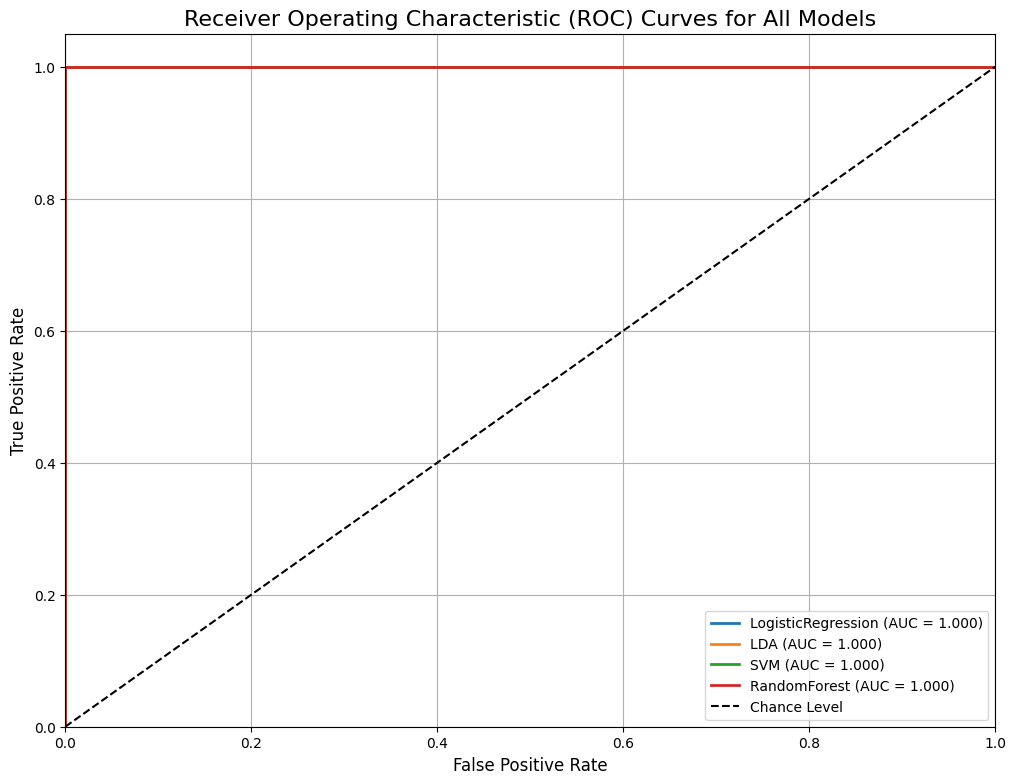

In [10]:
results = {}
plt.figure(figsize=(12, 9))

for name, model in trained_models.items():
    # Select appropriate test data (scaled or original)
    use_scaled = models_to_train[name]['use_scaled']
    X_test_data = X_test_scaled if use_scaled else X_test

    # Make predictions
    y_pred = model.predict(X_test_data)
    y_prob = model.predict_proba(X_test_data)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Store results for summary
    results[name] = {'Accuracy': accuracy, 'AUC': roc_auc}

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', lw=2)

    # Print detailed report for each model
    print(f"\n--- Evaluation Results for {name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"AUC Score: {roc_auc:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

# Finalize and show the combined ROC plot
plt.plot([0, 1], [0, 1], 'k--', label='Chance Level')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curves for All Models', fontsize=16)
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### Final Results Summary

In [11]:
summary_df = pd.DataFrame(results).T # Transpose to have models as rows
summary_df = summary_df.sort_values(by='AUC', ascending=False)

print("\n--- Final Model Performance Summary ---")
summary_df


--- Final Model Performance Summary ---


,Accuracy,AUC
LogisticRegression,0.998889,1.0
LDA,0.995556,1.0
SVM,0.998889,1.0
RandomForest,1.000000,1.0
